In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neerajsura1","key":"758d9cb9478aa3ce7f2a1edbfb1ab442"}'}

In [ ]:
# create a kaggle directory
! mkdir ~/.kaggle/
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces

 98% 681M/696M [00:05<00:00, 187MB/s]
100% 696M/696M [00:05<00:00, 128MB/s]


In [ ]:
# Unzip the dataset
!unzip animal-faces.zip -d animal-faces

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [ ]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.parallel
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable, grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# Set random seed for reproducible results
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "/content/animal-faces/afhq/train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28

# Number of training epochs
n_epochs = 20

# Learning rate for optimizers
lr = 0.001


In [ ]:
# Create the dataset with grayscale transformations
dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Grayscale(),  # Convert to grayscale
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),  # Output a tensor
                                   transforms.Normalize((0.5,), (0.5,)),  # Normalize for grayscale
                               ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cpu")

In [ ]:
store_path = "ddpm_animal.pt"

**Helper functions** \


In [ ]:
def show_images(images, title=""):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(10, 10))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
                ax.set_xticks([])  # Hide x-axis ticks
                ax.set_yticks([])  # Hide y-axis ticks
                idx += 1
    fig.suptitle(title, fontsize=22)

    # Showing the figure
    plt.show()


In [ ]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:100], "Images in the first batch")
        break

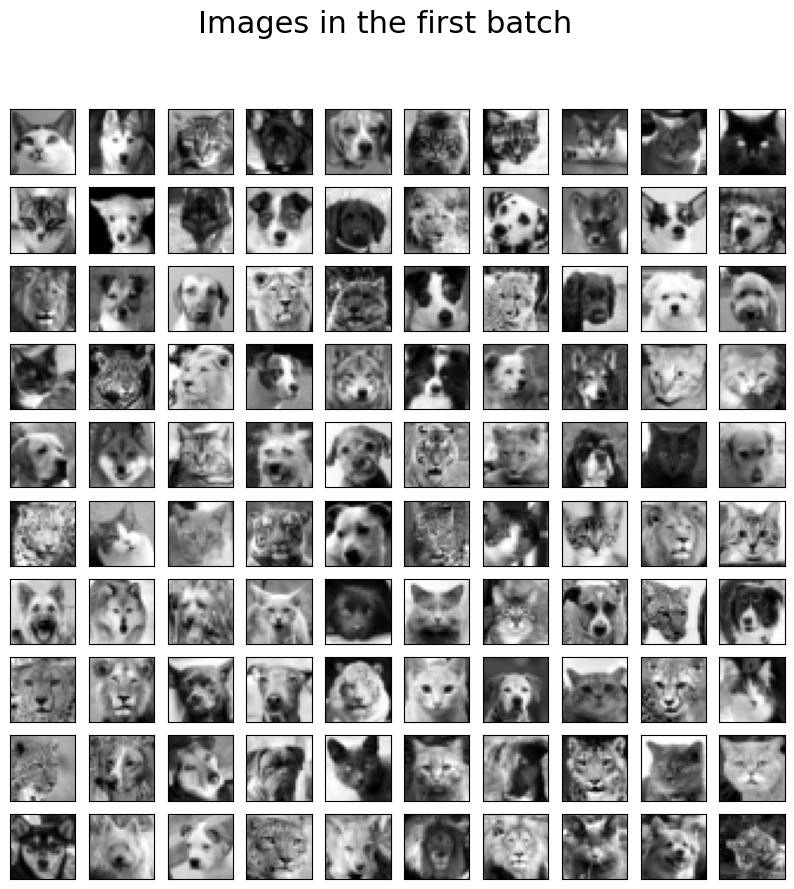

In [ ]:
# Optionally, show a batch of regular images
show_first_batch(dataloader)

In [ ]:
device = torch.device("cpu")

In [ ]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [ ]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0][:100]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [ ]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [ ]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, dataloader, device)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Saved best model ever"

        print(log_string)

In [ ]:
training_loop(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 1: 0.420 --> Saved best model ever


Epoch 2/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 2: 0.109 --> Saved best model ever


Epoch 3/20:   0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79948ffa5900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x79948ffa5900>
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():AssertionError
:   File "/usr/lib/python3.10/multiprocessing/pro

Loss at epoch 3: 0.084 --> Saved best model ever


Epoch 4/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 4: 0.077 --> Saved best model ever


Epoch 5/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 5: 0.074 --> Saved best model ever


Epoch 6/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 6: 0.072 --> Saved best model ever


Epoch 7/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 7: 0.072


Epoch 8/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 8: 0.070 --> Saved best model ever


Epoch 9/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 9: 0.070


Epoch 10/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 10: 0.068 --> Saved best model ever


Epoch 11/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 11: 0.067 --> Saved best model ever


Epoch 12/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 12: 0.065 --> Saved best model ever


Epoch 13/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 13: 0.065 --> Saved best model ever


Epoch 14/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 14: 0.065


Epoch 15/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 15: 0.066


Epoch 16/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 16: 0.064 --> Saved best model ever


Epoch 17/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 17: 0.063 --> Saved best model ever


Epoch 18/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 18: 0.063


Epoch 19/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 19: 0.063


Epoch 20/20:   0%|          | 0/115 [00:00<?, ?it/s]

Loss at epoch 20: 0.065


**Generating Images with 3 different n_steps**

In [ ]:
# Loading the trained model
n_steps = [100, 200, 900]
models = []
for n in n_steps:
    best_model = MyDDPM(MyUNet(), n_steps=n, device=device)
    best_model.load_state_dict(torch.load(store_path, map_location=device))
    best_model.eval()
    models.append(best_model)

Generating new images


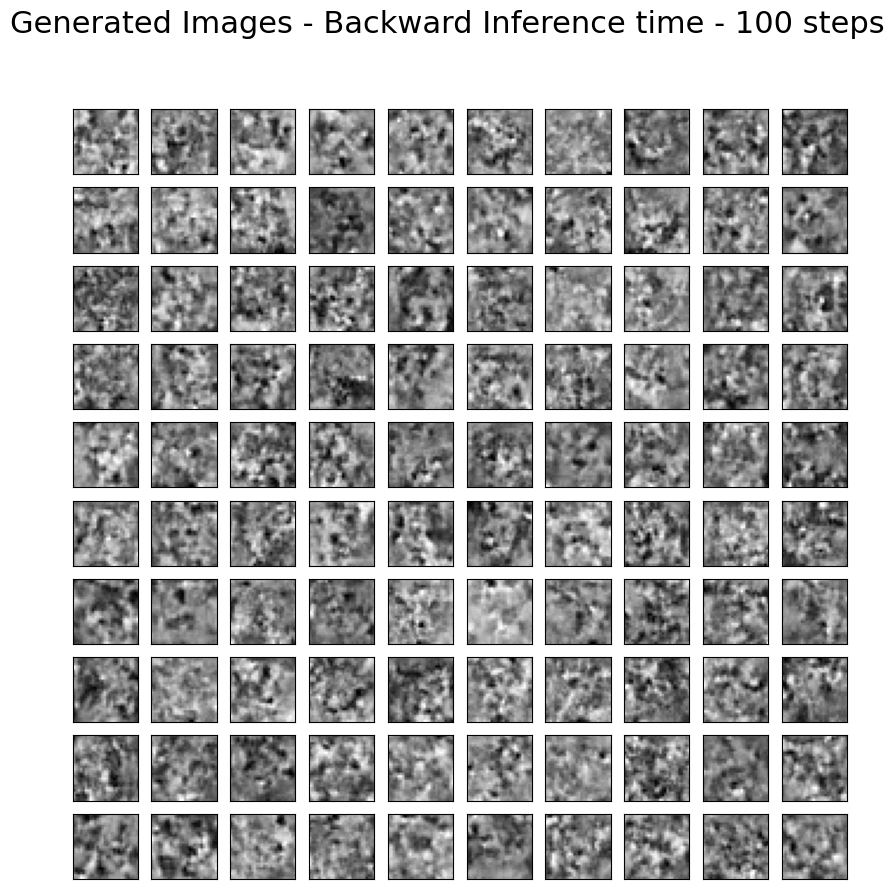

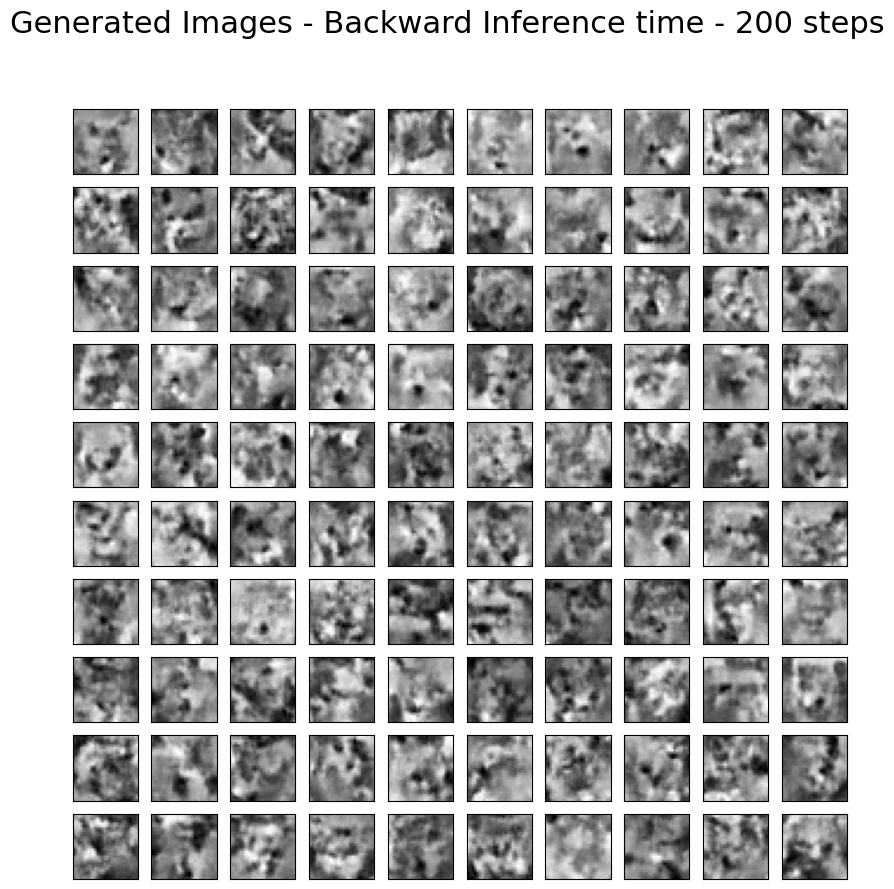

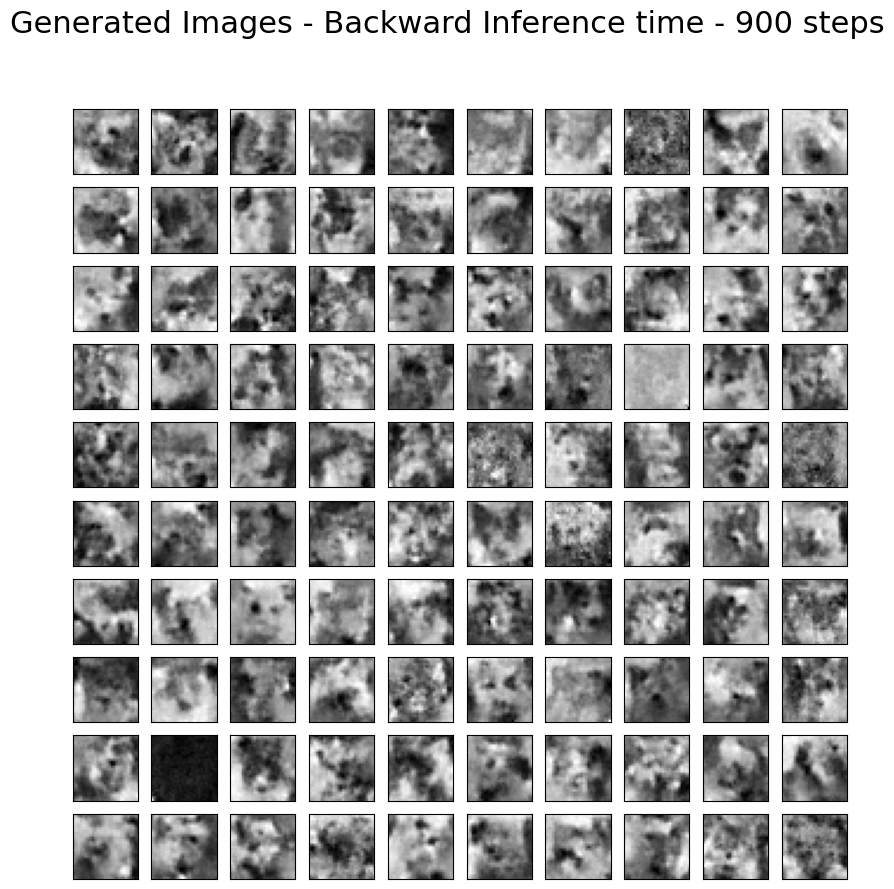

In [ ]:
print("Generating new images")
for i, model in enumerate(models):
    generated = generate_new_images(model,n_samples=100,device=device,gif_name="animal.gif")
    show_images(generated, f"Generated Images - Backward Inference time - {n_steps[i]} steps")

**Calculating FID score**

In [ ]:
!pip install torchmetrics[image]

In [ ]:
# Real Image tensor for calculating FID score
real_batch = next(iter(dataloader))
real_img_tensor = real_batch[0].to(device)[:100]
# create directories
#! mkdir ~/GeneratedImages_100steps/
#! mkdir ~/GeneratedImages_200steps/
#! mkdir ~/GeneratedImages_900steps/
#! mkdir ~/RealImages/

real_img_tensor = real_img_tensor.to(torch.uint8)
real_img_tensor = real_img_tensor.expand(-1, 3, -1, -1)
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64)
fid.update(real_img_tensor, real=True)

gen_img_tensor = generated
gen_img_tensor = gen_img_tensor.to(torch.uint8)
gen_img_tensor = gen_img_tensor.expand(-1, 3, -1, -1)

# Compute FID
fid.update(gen_img_tensor, real=False)
fid_score = fid.compute()
print(f'FID Score with best model is {fid_score}')

FID Score with best model is 83.27181243896484


In [ ]:
from IPython.display import Image

Image(open('animal.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

**-----------------------PROBLEM 2 : Self-supervised learning using Momentum Con-trast Encoder method (MoCO)-----------------------**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"neerajsura1","key":"758d9cb9478aa3ce7f2a1edbfb1ab442"}'}

In [ ]:
# create a kaggle directory
! mkdir ~/.kaggle/
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces

animal-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the dataset
!unzip animal-faces.zip -d animal-faces

In [ ]:
import numpy as np
import torch
import copy
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import os
import glob
from PIL import Image
from collections import OrderedDict
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import Subset
tsne = TSNE()

In [ ]:
# Root directory for dataset
dataroot = "/content/animal-faces/afhq/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.001

device = torch.device("cpu")

In [ ]:
train_names = sorted(glob.glob(dataroot+'/train/*/*.jpg',recursive=True))
test_names = sorted(glob.glob(dataroot+'/val/*/*.jpg',recursive=True))

print(len(train_names))
print(len(test_names))

# setting random seed to ensure the same 10% labelled data is used when training the linear classifier
random.seed(0)

names_train_10_percent = random.sample(train_names, len(train_names) // 100)
names_train = random.sample(train_names, len(train_names))
names_test = random.sample(test_names, len(test_names))

print(len(names_train_10_percent))
print(len(names_train))
print(len(names_test))


14630
1500
146
14630
1500


In [ ]:
# getting labels based on filenames, note that the filenames themselves contain classnames
# also note that these labels won't be used to actually train the base model
# these are just for visualization purposes
labels_train = [x.split('/')[6] for x in names_train]
labels_test = [x.split('/')[6] for x in names_test]
print(labels_train)
print(labels_test)
# these 10 percent labels will be used for training the linear classifer
labels_train_10_percent = [x.split('/')[6] for x in names_train_10_percent]
print(labels_train_10_percent)
print(len(labels_train_10_percent))

['dog', 'wild', 'cat', 'wild', 'cat', 'wild', 'dog', 'wild', 'dog', 'dog', 'cat', 'dog', 'dog', 'wild', 'wild', 'wild', 'wild', 'dog', 'cat', 'dog', 'wild', 'cat', 'dog', 'dog', 'wild', 'dog', 'wild', 'cat', 'cat', 'cat', 'wild', 'cat', 'cat', 'wild', 'cat', 'dog', 'wild', 'cat', 'dog', 'dog', 'wild', 'cat', 'cat', 'wild', 'cat', 'wild', 'wild', 'cat', 'cat', 'wild', 'dog', 'wild', 'dog', 'dog', 'wild', 'cat', 'cat', 'cat', 'wild', 'cat', 'wild', 'wild', 'dog', 'cat', 'dog', 'cat', 'dog', 'wild', 'cat', 'cat', 'wild', 'cat', 'cat', 'cat', 'wild', 'cat', 'dog', 'cat', 'wild', 'wild', 'cat', 'wild', 'cat', 'dog', 'dog', 'wild', 'cat', 'wild', 'cat', 'cat', 'cat', 'cat', 'wild', 'cat', 'dog', 'dog', 'cat', 'wild', 'dog', 'dog', 'cat', 'dog', 'cat', 'wild', 'dog', 'cat', 'cat', 'dog', 'wild', 'dog', 'wild', 'dog', 'cat', 'wild', 'wild', 'cat', 'wild', 'cat', 'wild', 'wild', 'cat', 'wild', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'wild', 'cat', 'cat', 'dog', 'wild', 'dog', 'dog', 'w

In [ ]:
# A function to perform color distortion in images
# It is used in SimCLR alongwith random resized cropping
# Here, s is the strength of color distortion.

def get_color_distortion(s=1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)

    # p is the probability of grayscale, here 0.2
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])

    return color_distort

In [ ]:
# this is the dataset class
class MyDataset(Dataset):
    def __init__(self, filenames, labels, mutation=False):
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(28)(img)
        res = get_color_distortion()(res)
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.file_names[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        image = T.Resize((28, 28))(image)

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((28, 28))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample


In [ ]:
# datasets
training_dataset_mutated = MyDataset(names_train, labels_train, mutation=True)
training_dataset = MyDataset(names_train_10_percent, labels_train_10_percent, mutation=False)
testing_dataset = MyDataset(names_test, labels_test, mutation=False)

# Select a random subset of 5000 images
subset_indices = torch.randperm(len(training_dataset_mutated))[:3000]

# Create a Subset of the original dataset
training_dataset_mutated = Subset(training_dataset_mutated, subset_indices)
training_dataset = Subset(training_dataset, subset_indices)
testing_dataset = Subset(testing_dataset, subset_indices)

# dataloaders
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=128, shuffle=True)
print(len(dataloader_training_dataset_mutated))
dataloader_training_dataset = DataLoader(training_dataset, batch_size=128, shuffle=True)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=128, shuffle=True)
K = 2000

24


In [ ]:
τ = 0.05

def loss_function(q, k, queue):

    N = q.shape[0]
    C = q.shape[1]

    pos = torch.exp(torch.div(torch.bmm(q.view(N,1,C), k.view(N,C,1)).view(N, 1),τ))
    neg = torch.sum(torch.exp(torch.div(torch.mm(q.view(N,C), torch.t(queue)),τ)), dim=1)
    denominator = neg + pos

    return torch.mean(-torch.log(torch.div(pos,denominator)))


In [ ]:
# defining our deep learning architecture
resnetq = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnetq.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnetq.fc = classifier
resnetk = copy.deepcopy(resnetq)

# moving the resnet architecture to device
resnetq.to(device)
resnetk.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Defining data structures for storing training info

losses_train = []
num_epochs = 20

flag = 0

queue = None

# using SGD optimizer
optimizer = optim.SGD(resnetq.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)

!mkdir /content/moco-results/
%cd /content/moco-results/

if not os.path.exists('results'):
    os.makedirs('results')

%cd ..

if queue is None:
    while True:

        with torch.no_grad():
            for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):

                xk = sample_batched['image2']
                xk = xk.to(device)
                k = resnetk(xk)
                k = k.detach()

                k = torch.div(k,torch.norm(k,dim=1).reshape(-1,1))

                if queue is None:
                    queue = k
                else:
                    print(queue.shape[0])
                    if queue.shape[0] < K:
                        queue = torch.cat((queue, k), 0)
                    else:
                        print('setting flag = 1')
                        flag = 1

                if flag == 1:
                    print('Breaking for loop')
                    break

        if flag == 1:
            print('break while loop')
            break



mkdir: cannot create directory ‘/content/moco-results/’: File exists
/content/moco-results
/content
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
setting flag = 1
Breaking for loop
break while loop


[0/20] [0/24] Loss = 8.39960765838623
[0/20] [6/24] Loss = 8.060545921325684
[0/20] [12/24] Loss = 7.951371192932129
[0/20] [18/24] Loss = 7.809259414672852
[1/20] [0/24] Loss = 8.01710319519043
[1/20] [6/24] Loss = 7.827487945556641
[1/20] [12/24] Loss = 7.73963737487793
[1/20] [18/24] Loss = 7.738399982452393
[2/20] [0/24] Loss = 7.744141578674316
[2/20] [6/24] Loss = 7.862785339355469
[2/20] [12/24] Loss = 7.86696720123291
[2/20] [18/24] Loss = 7.790871620178223
[3/20] [0/24] Loss = 7.731990814208984
[3/20] [6/24] Loss = 7.6095991134643555
[3/20] [12/24] Loss = 7.74058198928833
[3/20] [18/24] Loss = 7.570361614227295
[4/20] [0/24] Loss = 7.75366735458374
[4/20] [6/24] Loss = 7.672956466674805
[4/20] [12/24] Loss = 7.488080978393555
[4/20] [18/24] Loss = 7.639776229858398
[5/20] [0/24] Loss = 7.631046772003174
[5/20] [6/24] Loss = 7.748952388763428
[5/20] [12/24] Loss = 7.694839000701904
[5/20] [18/24] Loss = 7.682712554931641
[6/20] [0/24] Loss = 7.6490478515625
[6/20] [6/24] Loss =

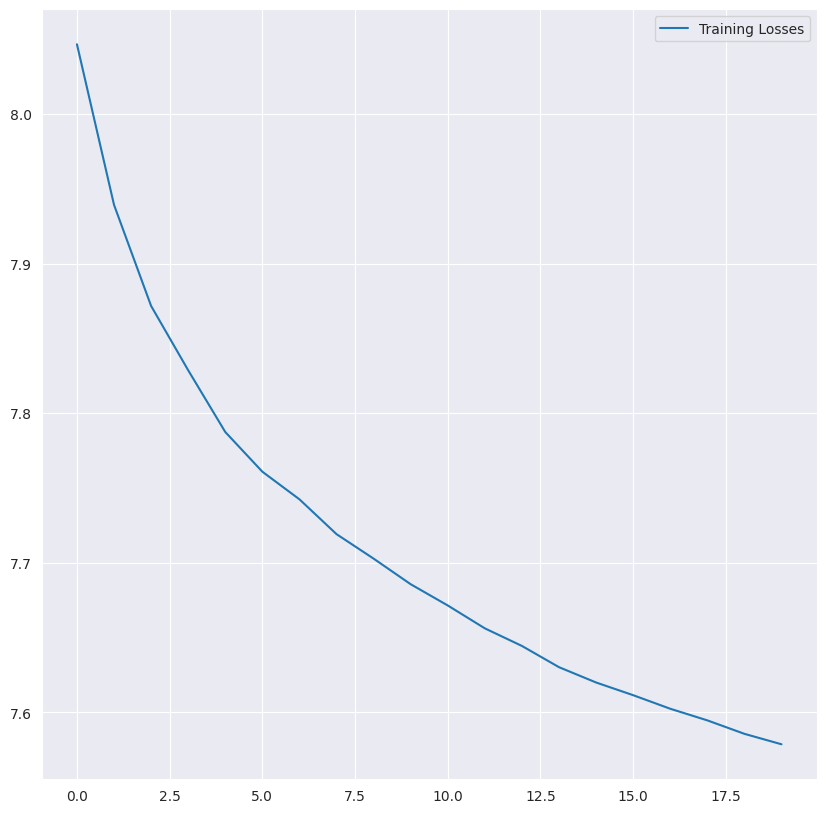

In [ ]:
# Boolean variable on whether to perform training or not
TRAINING = True
momentum = 0.999
num_epochs = 20
def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode

    resnetq.train()

    # a list to store losses for each epoch
    epoch_losses_train = []

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        #print(epoch)



        # run a for loop for each batch
        for (i, sample_batched) in enumerate(dataloader_training_dataset_mutated):

            # zero out grads
            optimizer.zero_grad()

            # retrieve xq and xk the two image batches
            xq = sample_batched['image1']
            xk = sample_batched['image2']

            # move them to the device
            xq = xq.to(device)
            xk = xk.to(device)

            # get their outputs
            q = resnetq(xq)
            k = resnetk(xk)
            k = k.detach()

            q = torch.div(q,torch.norm(q,dim=1).reshape(-1,1))
            k = torch.div(k,torch.norm(k,dim=1).reshape(-1,1))

            # get loss value
            loss = loss_function(q, k, queue)

            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

            # update the queue
            queue = torch.cat((queue, k), 0)

            if queue.shape[0] > K:
                queue = queue[256:,:]

            # update resnetk
            for θ_k, θ_q in zip(resnetk.parameters(), resnetq.parameters()):
                θ_k.data.copy_(momentum*θ_k.data + θ_q.data*(1.0 - momentum))

            # Output training stats
            if i % 6 == 0:
                print(f'[{epoch}/{num_epochs}] [{i}/{len(dataloader_training_dataset_mutated)}] Loss = {loss}')

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Store model and optimizer files
        torch.save(resnetq.state_dict(), '/content/moco-results/results/modelq.pth')
        torch.save(resnetk.state_dict(), '/content/moco-results/results/modelk.pth')
        torch.save(optimizer.state_dict(), '/content/moco-results/results/optimizer.pth')
        np.savez("/content/moco-results/results/lossesfile", np.array(losses_train))
        torch.save(queue, '/content/moco-results/results/queue.pt')


    # Plot the training losses Graph and save it
    fig = plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(losses_train)
    plt.legend(['Training Losses'])
    plt.savefig('losses.png')
    plt.show()


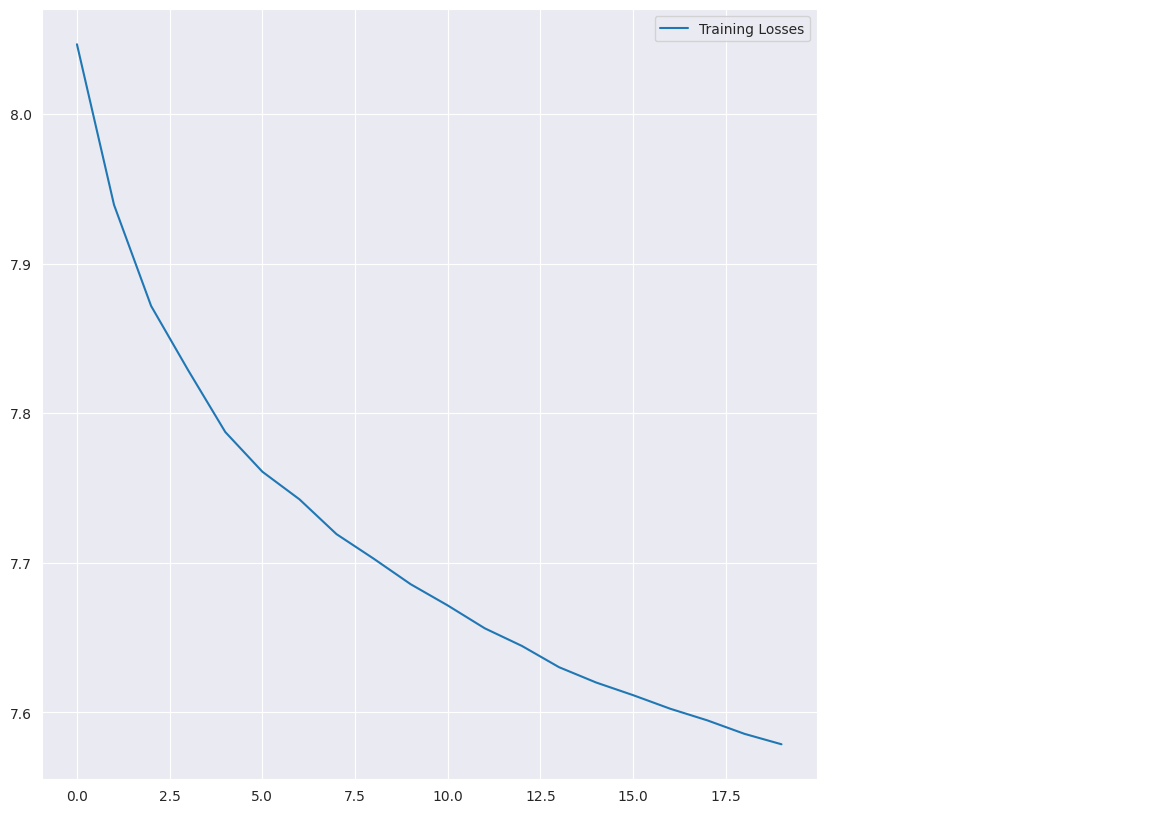

**Experiment Report**

**Problem 1:Construct a DDPM on the animal face data.  Experiment with three different values of backward inference time - Plot a grid of 10by  10  images  for  all  three  cases  and  compute  the  FID.  Take  the  VAEimplemented in Assignment 1 and use it to implement a class-conditionalDDPM on its latent space.  Use classifier guidance with the score-basedformulation**

**Experiment Details**

Dataset: Animal Faces dataset

Data Preprocessing: Downsized images to 28x28 pixels, grayscaled and normalized

Loss used = MSE between the noise plugged and the predicted noise

Epochs : 20

Generated Images of all three categories using 3 different values of backward inference time.

Calculated the FID score

Plotted 10x10 image grids as asked in the question

PLotted a gif to show the generation of images from noisy image samples.

**Results**
Forward diffusion process was gradual as seen in the plotted grids.
We see the backward inference time has a major impact on generation quality.
D-KL between q(X_t-1| X_t, X_0) and p(X_t-1|X_t) is minimized.

**Problem 2:Implement Self-supervised learning using Momentum Con-trast Encoder method (MoCO). Try 3 sets of augmentation methods.  Im-plement a linear classifier on the learnt representations.  Compare it witha full-blown CNN, that has the same number of parameters.  Record thereduction in the amount of supervised data needed.**

**Experiment Details**

Dataset: Animal Faces dataset

Data Preprocessing: Downsized images to 28x28 pixels and normalized

Loss used = Implenmented InfoNCE Loss

Epochs - 20

Pretext Task - Solve a 3 class claffication problem.

**Results/Observation**
Loss is gradually decreasing as num_epochs are increasing, model needs more training.

